In [1]:
!pip install statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
data = pd.read_csv('/work/kaggle_flight_prices/ca_sample_data.csv')

In [3]:
"""
Variable Descriptions

legId: An identifier for the flight.
searchDate: The date (YYYY-MM-DD) on which this entry was taken from Expedia.
flightDate: The date (YYYY-MM-DD) of the flight.
startingAirport: Three-character IATA airport code for the initial location.
destinationAirport: Three-character IATA airport code for the arrival location.
fareBasisCode: The fare basis code.
travelDuration: The travel duration in hours and minutes.
elapsedDays: The number of elapsed days (usually 0).
isBasicEconomy: Boolean for whether the ticket is for basic economy.
isRefundable: Boolean for whether the ticket is refundable.
isNonStop: Boolean for whether the flight is non-stop.
baseFare: The price of the ticket (in USD).
totalFare: The price of the ticket (in USD) including taxes and other fees.
seatsRemaining: Integer for the number of seats remaining.
totalTravelDistance: The total travel distance in miles. This data is sometimes missing.
segmentsDepartureTimeEpochSeconds: String containing the departure time (Unix time) for each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsDepartureTimeRaw: String containing the departure time (ISO 8601 format: YYYY-MM-DDThh:mm:ss.000±[hh]:00) for each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsArrivalTimeEpochSeconds: String containing the arrival time (Unix time) for each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsArrivalTimeRaw: String containing the arrival time (ISO 8601 format: YYYY-MM-DDThh:mm:ss.000±[hh]:00) for each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsArrivalAirportCode: String containing the IATA airport code for the arrival location for each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsDepartureAirportCode: String containing the IATA airport code for the departure location for each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsAirlineName: String containing the name of the airline that services each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsAirlineCode: String containing the two-letter airline code that services each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsEquipmentDescription: String containing the type of airplane used for each leg of the trip (e.g. "Airbus A321" or "Boeing 737-800"). The entries for each of the legs are separated by '||'.
segmentsDurationInSeconds: String containing the duration of the flight (in seconds) for each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsDistance: String containing the distance traveled (in miles) for each leg of the trip. The entries for each of the legs are separated by '||'.
segmentsCabinCode: String containing the cabin for each leg of the trip (e.g. "coach"). The entries for each of the legs are separated by '||'.
"""

'\nVariable Descriptions\n\nlegId: An identifier for the flight.\nsearchDate: The date (YYYY-MM-DD) on which this entry was taken from Expedia.\nflightDate: The date (YYYY-MM-DD) of the flight.\nstartingAirport: Three-character IATA airport code for the initial location.\ndestinationAirport: Three-character IATA airport code for the arrival location.\nfareBasisCode: The fare basis code.\ntravelDuration: The travel duration in hours and minutes.\nelapsedDays: The number of elapsed days (usually 0).\nisBasicEconomy: Boolean for whether the ticket is for basic economy.\nisRefundable: Boolean for whether the ticket is refundable.\nisNonStop: Boolean for whether the flight is non-stop.\nbaseFare: The price of the ticket (in USD).\ntotalFare: The price of the ticket (in USD) including taxes and other fees.\nseatsRemaining: Integer for the number of seats remaining.\ntotalTravelDistance: The total travel distance in miles. This data is sometimes missing.\nsegmentsDepartureTimeEpochSeconds: St

In [4]:
daily_avg_prices = data.groupby('flightDate', as_index=False)['baseFare'].mean()
daily_avg_prices.rename(columns={'baseFare': 'avg_baseFare'}, inplace=True)
daily_avg_prices.head()

,flightDate,avg_baseFare
0,2022-04-17,401.764660
1,2022-04-18,433.317187
2,2022-04-19,363.029368
3,2022-04-20,364.988059
4,2022-04-21,449.122950


In [5]:
# Create a new column to indicate if the flight is a holiday
daily_avg_prices['flightDate'] = pd.to_datetime(daily_avg_prices['flightDate'])

holidays = ['2022-05-27', '2022-05-28', '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-17', 
                '2022-06-18', '2022-06-19', '2022-06-20', '2022-07-01', '2022-07-02', '2022-07-03', '2022-07-04', '2022-07-05', 
                '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06', '2022-11-11', '2022-11-17', '2022-11-18'
            ] 
holidays = pd.to_datetime(holidays) 

def is_holiday(date):
    return 1 if date.date() in holidays.date else 0

daily_avg_prices['isHoliday'] = daily_avg_prices['flightDate'].apply(is_holiday)
daily_avg_prices['day_of_week'] = daily_avg_prices['flightDate'].dt.dayofweek
daily_avg_prices

,flightDate,avg_baseFare,isHoliday,day_of_week
0,2022-04-17,401.764660,0,6
1,2022-04-18,433.317187,0,0
2,2022-04-19,363.029368,0,1
3,2022-04-20,364.988059,0,2
4,2022-04-21,449.122950,0,3
...,...,...,...,...
212,2022-11-15,234.250296,0,1
213,2022-11-16,270.498691,0,2
214,2022-11-17,386.663089,1,3
215,2022-11-18,417.632034,1,4


In [6]:
daily_avg_prices = daily_avg_prices.sort_values(by='flightDate')
daily_avg_prices

,flightDate,avg_baseFare,isHoliday,day_of_week
0,2022-04-17,401.764660,0,6
1,2022-04-18,433.317187,0,0
2,2022-04-19,363.029368,0,1
3,2022-04-20,364.988059,0,2
4,2022-04-21,449.122950,0,3
...,...,...,...,...
212,2022-11-15,234.250296,0,1
213,2022-11-16,270.498691,0,2
214,2022-11-17,386.663089,1,3
215,2022-11-18,417.632034,1,4


In [7]:
num_lags = 8

for lag in range(1, num_lags + 1): 
    daily_avg_prices[f'PriceLag{lag}'] = daily_avg_prices['avg_baseFare'].shift(lag)


daily_avg_prices = daily_avg_prices.dropna()

# Train-test split based on flightDate
train_data = daily_avg_prices[daily_avg_prices['flightDate'] < '2022-10-01']
test_data = daily_avg_prices[daily_avg_prices['flightDate'] >= '2022-10-01']

formula = "avg_baseFare ~ isHoliday +  day_of_week +" + " + ".join(
    [f"PriceLag{lag}" for lag in range(1, num_lags + 1)]
)

ar_model = smf.ols(formula=formula, data=train_data).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           avg_baseFare   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     79.02
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           3.23e-54
Time:                        00:11:46   Log-Likelihood:                -747.41
No. Observations:                 159   AIC:                             1517.
Df Residuals:                     148   BIC:                             1551.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -18.9219     17.380     -1.089      0.278     -53.267      15.423
isHoliday     -13.9435      7.090     -1.967      0.051     -27.955       0.068
day_of_week    12.5930      1.650      7.632      0.000       9.332      15.854
PriceLag1       0.6726      0.061     11.086      0.000       0.553       0.792
PriceLag2      -0.2468      0.065     -3.818      0.000      -0.375      -0.119
PriceLag3       0.2720      0.066      4.094      0.000       0.141       0.403
PriceLag4       0.2529      0.070      3.592      0.000       0.114       0.392
PriceLag5       0.0497      0.066      0.757      0.450      -0.080       0.179
PriceLag6      -0.1422      0.066     -2.154      0.033      -0.273      -0.012
PriceLag7       0.3193      0.077      4.140      0.000       0.167       0.472
PriceLag8      -0.2260      0.065     -3.479      0.001      -0.354      -0.098
==============================================================================
Omnibus:                       16.357   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.690
Skew:                           0.564   Prob(JB):                     4.35e-06
Kurtosis:                       4.566   Cond. No.                     9.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
test_data

,flightDate,avg_baseFare,isHoliday,day_of_week,PriceLag1,PriceLag2,PriceLag3,PriceLag4,PriceLag5,PriceLag6,PriceLag7,PriceLag8
167,2022-10-01,292.124812,0,5,334.697231,330.339258,288.693159,278.546407,311.868558,357.474019,288.415969,373.866404
168,2022-10-02,359.944467,0,6,292.124812,334.697231,330.339258,288.693159,278.546407,311.868558,357.474019,288.415969
169,2022-10-03,299.704964,0,0,359.944467,292.124812,334.697231,330.339258,288.693159,278.546407,311.868558,357.474019
170,2022-10-04,273.807626,0,1,299.704964,359.944467,292.124812,334.697231,330.339258,288.693159,278.546407,311.868558
171,2022-10-05,298.379458,0,2,273.807626,299.704964,359.944467,292.124812,334.697231,330.339258,288.693159,278.546407
172,2022-10-06,361.729195,0,3,298.379458,273.807626,299.704964,359.944467,292.124812,334.697231,330.339258,288.693159
173,2022-10-07,367.817733,0,4,361.729195,298.379458,273.807626,299.704964,359.944467,292.124812,334.697231,330.339258
174,2022-10-08,304.714036,0,5,367.817733,361.729195,298.379458,273.807626,299.704964,359.944467,292.124812,334.697231
175,2022-10-09,390.490422,0,6,304.714036,367.817733,361.729195,298.379458,273.807626,299.704964,359.944467,292.124812
176,2022-10-10,374.678961,0,0,390.490422,304.714036,367.817733,361.729195,298.379458,273.807626,299.704964,359.944467


In [9]:
daily_avg_prices

,flightDate,avg_baseFare,isHoliday,day_of_week,PriceLag1,PriceLag2,PriceLag3,PriceLag4,PriceLag5,PriceLag6,PriceLag7,PriceLag8
8,2022-04-25,450.571817,0,0,569.353899,481.453768,473.298975,449.122950,364.988059,363.029368,433.317187,401.764660
9,2022-04-26,364.139335,0,1,450.571817,569.353899,481.453768,473.298975,449.122950,364.988059,363.029368,433.317187
10,2022-04-27,351.340682,0,2,364.139335,450.571817,569.353899,481.453768,473.298975,449.122950,364.988059,363.029368
11,2022-04-28,403.054371,0,3,351.340682,364.139335,450.571817,569.353899,481.453768,473.298975,449.122950,364.988059
12,2022-04-29,416.360574,0,4,403.054371,351.340682,364.139335,450.571817,569.353899,481.453768,473.298975,449.122950
...,...,...,...,...,...,...,...,...,...,...,...,...
212,2022-11-15,234.250296,0,1,314.355283,378.280204,262.857894,307.923922,328.326345,257.010040,230.684558,289.296897
213,2022-11-16,270.498691,0,2,234.250296,314.355283,378.280204,262.857894,307.923922,328.326345,257.010040,230.684558
214,2022-11-17,386.663089,1,3,270.498691,234.250296,314.355283,378.280204,262.857894,307.923922,328.326345,257.010040
215,2022-11-18,417.632034,1,4,386.663089,270.498691,234.250296,314.355283,378.280204,262.857894,307.923922,328.326345


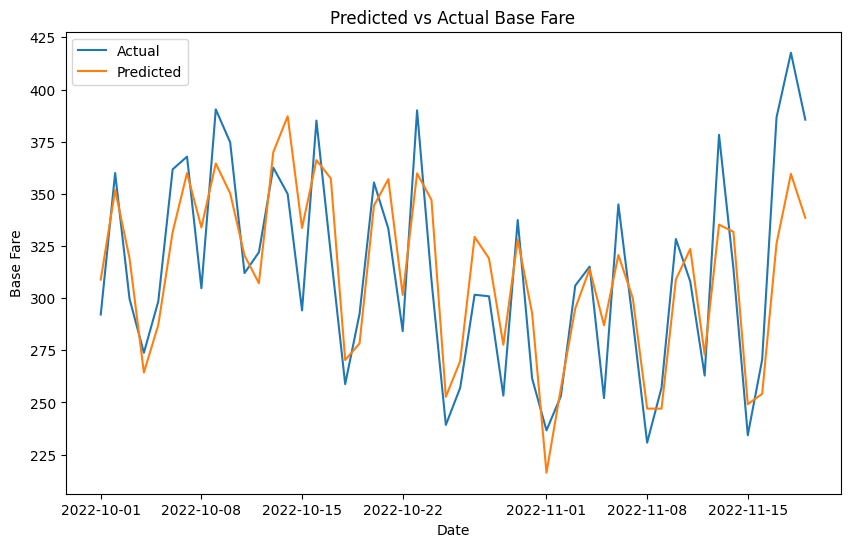

In [10]:
exog_vars = ['isHoliday', 'day_of_week'] + [f"PriceLag{lag}" for lag in range(1, num_lags + 1)]
predictions = ar_model.predict(exog=test_data[exog_vars])

plt.figure(figsize=(10, 6))
plt.plot(test_data['flightDate'], test_data['avg_baseFare'], label='Actual')
plt.plot(test_data['flightDate'], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Base Fare')
plt.title('Predicted vs Actual Base Fare')
plt.legend()
plt.show()

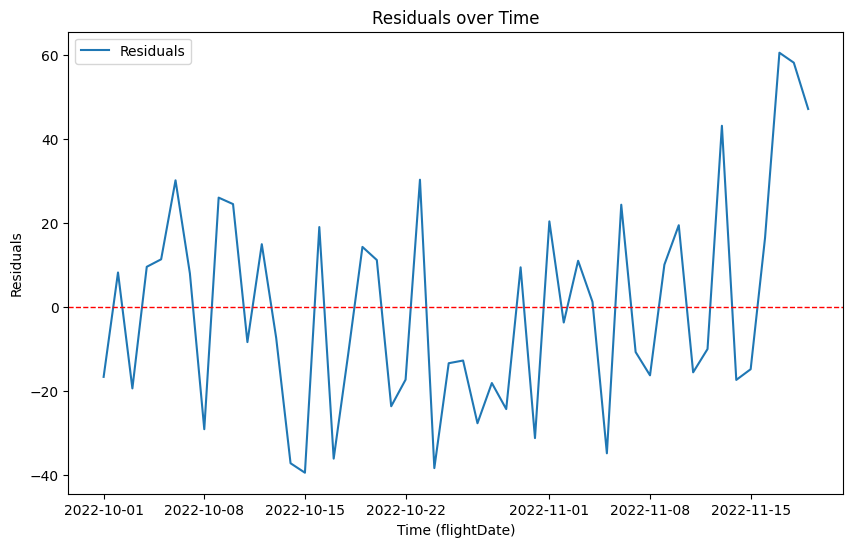

In [12]:
residuals = test_data['avg_baseFare'] - predictions

if len(test_data['flightDate']) != len(residuals):
    min_length = min(len(test_data['flightDate']), len(residuals))
    residuals = residuals[:min_length]
    flight_dates = test_data['flightDate'][:min_length]
else:
    flight_dates = test_data['flightDate']

plt.figure(figsize=(10, 6))
plt.plot(flight_dates, residuals, label='Residuals')
plt.xlabel('Time (flightDate)')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.show()

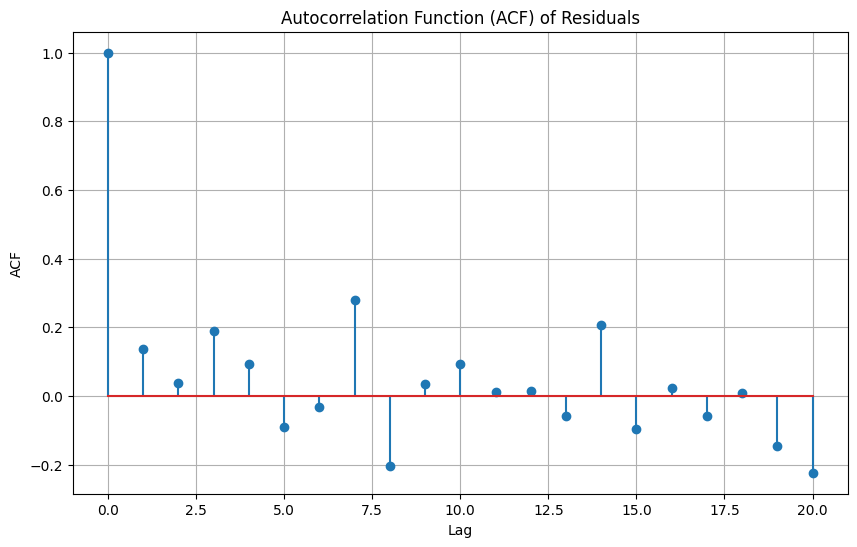

In [13]:
import statsmodels.api as sm

acf_result = sm.tsa.acf(residuals, nlags=20) 

plt.figure(figsize=(10, 6))
plt.stem(acf_result)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.grid(True)
plt.show()

In [15]:
def OSR2(model, X_test, y_test, y_train):

    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)

    return (1 - SSE/SST)

In [16]:
def OSR2(model, df_train, df_test, dependent_var, feature_cols):
    # df_train: training data
    # df_test: testing data
    # dependent_var: target variable (e.g., 'CivicSales')
    # feature_cols: list of feature columns used for prediction

    y_test = df_test[dependent_var]  # Specify the dependent variable in the test data

    # Align test data with the training data (same feature columns)
    df_test = df_test[feature_cols]  # Only keep the relevant columns from test data
    df_test_sm = sm.add_constant(df_test)  # Add constant to test set

    # Make predictions on the test data
    y_pred = model.predict(df_test_sm)  # Predict using the test set

    # Calculate the Sum of Squared Errors (SSE) and Total Sum of Squares (SST)
    SSE = np.sum((y_pred - y_test)**2)  # Squared differences between predicted and actual
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)  # Squared differences from the mean

    # Calculate OSR^2
    return 1 - SSE/SST

In [17]:
test_data = test_data.iloc[1:]
osr2_value = OSR2(ar_model, train_data, test_data, 'avg_baseFare', exog_vars)
print(f"OSR2: {osr2_value}")

OSR2: 0.9359019069534521


In [18]:
y_test = test_data['avg_baseFare']
df_test = test_data[exog_vars] 
df_test_sm = sm.add_constant(test_data)  
y_pred = ar_model.predict(df_test_sm)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

print("RMSE:", rmse)

RMSE: 25.14774578188706


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=36e46b6c-b77a-4f8c-a857-c3dc2e354e3d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>